<a href="https://colab.research.google.com/github/danon6868/BI-ml-course/blob/main/lecture_8_neural_networks_part2/homework/FC_NN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [1]:
#import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output
#import torch.nn as nn
#import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import Image

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [2]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [3]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:** что чем больше размер батча, тем быстрее происходит обучение, потому что меньшее количество раз модель приходится обновлять веса. С другой стороны, быстрое обучение и редкой актуализацией весов может снизить качество предсказания, так что, видимо, когда-то надо будет научиться искать в них баланс.

Посмотрим на какую-нибудь картинку:

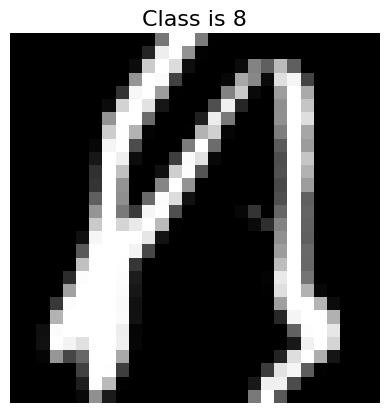

In [4]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





In [5]:
# just in case I check the number of classes in dataset
class_set = set()
for smpl in trainset:
        class_set.add(smpl[1])
class_set

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

''

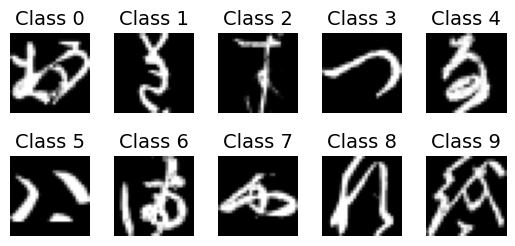

In [6]:
for pic_class in range(10):
    for smpl in trainset:
        if smpl[1] == pic_class:
            plt.subplot(2, 5, pic_class + 1)
            plt.imshow(smpl[0].view(28, 28).numpy(), cmap="gray")
            plt.axis("off")
            plt.title(f"Class {smpl[1]}", fontsize=14)
            break
plt.subplots_adjust(wspace=0.3, hspace=-0.5)
;

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.
 
https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [7]:
import torch.nn as nn

class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        ## YOUR CODE HERE
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        self.activation = nn.ReLU()        

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        ## YOUR CODE HERE
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        logits = self.fc3(x)

        return logits

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:** 235146

In [8]:
neuronet = FCNet()
num_feat = 0
for param in neuronet.parameters():
    num_feat += param.view(-1).shape[0]
num_feat

235146

### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [9]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    
    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [10]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [11]:
n_epochs = 10
loss_history = []

## YOUR CODE HERE
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # батч картинок для обучения
        optimizer.zero_grad() # обнуление градиента (неважно в первую эпоху, но дальше более чем)
        outputs = fc_net(images) # предсказания
        loss = loss_function(outputs, labels) # потеря
        loss.backward() # подсчет градиентов
        optimizer.step() # шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.9270
Epoch=2 loss=0.4565
Epoch=3 loss=0.3541
Epoch=4 loss=0.2944
Epoch=5 loss=0.2502
Epoch=6 loss=0.2157
Epoch=7 loss=0.1888
Epoch=8 loss=0.1648
Epoch=9 loss=0.1450
Epoch=10 loss=0.1282


In [12]:
get_accuracy(fc_net, testloader)

0.8776

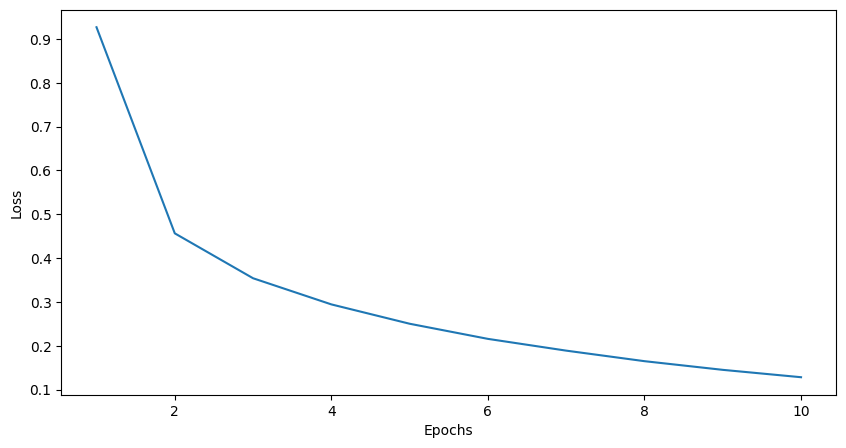

In [13]:
plt.figure(figsize=(10,5))
plt.plot([i+1 for i in range(n_epochs)], loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [14]:
mean = 0
std = 0
for sample, _ in trainset:
    mean += sample.mean()
    std += sample.std()
mean = mean / len(trainset)
std = std / len(trainset)
print(f"Mean: {mean}, std: {std}")

Mean: 0.19176195561885834, std: 0.3385268747806549


In [15]:
print(mean, std)

transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm 
testset.transform = transform_with_norm

tensor(0.1918) tensor(0.3385)


In [16]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [17]:
n_epochs = 10
loss_history = []

## YOUR CODE HERE
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # батч картинок для обучения
        optimizer.zero_grad() # обнуление градиента (неважно в первую эпоху, но дальше более чем)
        outputs = fc_net(images) # предсказания
        loss = loss_function(outputs, labels) # потеря
        loss.backward() # подсчет градиентов
        optimizer.step() # шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.6868
Epoch=2 loss=0.3008
Epoch=3 loss=0.2212
Epoch=4 loss=0.1715
Epoch=5 loss=0.1374
Epoch=6 loss=0.1110
Epoch=7 loss=0.0889
Epoch=8 loss=0.0727
Epoch=9 loss=0.0600
Epoch=10 loss=0.0476


In [18]:
get_accuracy(fc_net, testloader)

0.8953

Как изменилась `accuracy` после нормализации?

Повысилась. Делаем вывод, что стандартизация данных - хорошо всегда, даже если изначально её использование было контринтуитивным.

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

In [19]:
class FCNet_2(nn.Module):
    def __init__(self, activation):
        super().__init__() 
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        self.activation = activation        

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        logits = self.fc3(x)

        return logits

In [20]:
## YOUR CODE HERE
activations = [nn.ReLU(), nn.Sigmoid(), nn.GELU(), nn.Tanh(), nn.ELU(), nn.Softplus()]

In [39]:
n_epochs = 10
accurasy_hist = []

## YOUR CODE HERE
for activation in activations:
    print(f"activation function: {activation}")
    fc_net = FCNet_2(activation=activation)
    loss_function = nn.CrossEntropyLoss() # да, я понимаю, что этот кусок кода избыточен, но мне пока что для себя надо так
    lr = 0.001 # этот параметр тоже стоило бы не перезадавать, но я лучше обучаюсь на повторениях
    optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)
    loss_history = []
    for epoch in range(n_epochs):
        epoch_loss = 0
        for images, labels in trainloader: 
            optimizer.zero_grad() # всегда обнулять градиент
            outputs = fc_net(images) # предсказание
            loss = loss_function(outputs, labels) # потеря
            loss.backward() # подсчет градиента
            optimizer.step() # шаг спуска

            epoch_loss += loss.item()

        loss_history.append(epoch_loss/len(trainloader))
        print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")   
    print(f"accuracy: {get_accuracy(fc_net, testloader)}")
    print()
    accurasy_hist.append((str(activation), get_accuracy(fc_net, testloader)))

activation function: ReLU()
Epoch=1 loss=0.6779
Epoch=2 loss=0.3010
Epoch=3 loss=0.2233
Epoch=4 loss=0.1736
Epoch=5 loss=0.1386
Epoch=6 loss=0.1136
Epoch=7 loss=0.0920
Epoch=8 loss=0.0763
Epoch=9 loss=0.0627
Epoch=10 loss=0.0499
accuracy: 0.8969

activation function: Sigmoid()
Epoch=1 loss=1.5578
Epoch=2 loss=0.7667
Epoch=3 loss=0.5524
Epoch=4 loss=0.4476
Epoch=5 loss=0.3768
Epoch=6 loss=0.3223
Epoch=7 loss=0.2783
Epoch=8 loss=0.2426
Epoch=9 loss=0.2131
Epoch=10 loss=0.1880
accuracy: 0.8587

activation function: GELU(approximate='none')
Epoch=1 loss=0.6542
Epoch=2 loss=0.2815
Epoch=3 loss=0.2021
Epoch=4 loss=0.1561
Epoch=5 loss=0.1223
Epoch=6 loss=0.0969
Epoch=7 loss=0.0778
Epoch=8 loss=0.0623
Epoch=9 loss=0.0495
Epoch=10 loss=0.0386
accuracy: 0.9024

activation function: Tanh()
Epoch=1 loss=0.7759
Epoch=2 loss=0.3808
Epoch=3 loss=0.2559
Epoch=4 loss=0.1834
Epoch=5 loss=0.1362
Epoch=6 loss=0.1028
Epoch=7 loss=0.0763
Epoch=8 loss=0.0577
Epoch=9 loss=0.0415
Epoch=10 loss=0.0302
accuracy:

In [40]:
accurasy_hist

[('ReLU()', 0.8969),
 ('Sigmoid()', 0.8587),
 ("GELU(approximate='none')", 0.9024),
 ('Tanh()', 0.8972),
 ('ELU(alpha=1.0)', 0.8966),
 ('Softplus(beta=1, threshold=20)', 0.8845)]

С использованием какой функции активации удалось досчить наибольшей `accuracy`?

GELU, even though I've tried additional functions (chose them randomly just for fun)

Actually, I've run this cell multiple times. The result is unstable: either ReLU or Tanh shows the best performance.

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

In [23]:
optimizers = {
    "Adam": torch.optim.Adam,
    "RMSprop": torch.optim.RMSprop,
    "Adagrad": torch.optim.Adagrad
}

In [45]:
n_epochs = 10
accurasy_hist = []

for name, opt in optimizers.items():
    print(f"optimizer: {name}")
    fc_net = FCNet_2(activation=nn.ReLU())
    loss_function = nn.CrossEntropyLoss()
    lr = 0.001
    optimizer = opt(fc_net.parameters(), lr=3e-4)
    loss_history = []
    for epoch in range(n_epochs):
        epoch_loss = 0
        for images, labels in trainloader: 
            optimizer.zero_grad()
            outputs = fc_net(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()

        loss_history.append(epoch_loss/len(trainloader))
        print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")   
    print(f"accuracy: {get_accuracy(fc_net, testloader)}")
    print()
    accurasy_hist.append((name, get_accuracy(fc_net, testloader)))

optimizer: Adam
Epoch=1 loss=0.6782
Epoch=2 loss=0.3004
Epoch=3 loss=0.2220
Epoch=4 loss=0.1720
Epoch=5 loss=0.1363
Epoch=6 loss=0.1109
Epoch=7 loss=0.0901
Epoch=8 loss=0.0745
Epoch=9 loss=0.0601
Epoch=10 loss=0.0492
accuracy: 0.8984

optimizer: RMSprop
Epoch=1 loss=0.4675
Epoch=2 loss=0.2543
Epoch=3 loss=0.1902
Epoch=4 loss=0.1479
Epoch=5 loss=0.1178
Epoch=6 loss=0.0957
Epoch=7 loss=0.0783
Epoch=8 loss=0.0629
Epoch=9 loss=0.0507
Epoch=10 loss=0.0406
accuracy: 0.8705

optimizer: Adagrad
Epoch=1 loss=1.4041
Epoch=2 loss=0.8628
Epoch=3 loss=0.7257
Epoch=4 loss=0.6582
Epoch=5 loss=0.6161
Epoch=6 loss=0.5855
Epoch=7 loss=0.5627
Epoch=8 loss=0.5438
Epoch=9 loss=0.5281
Epoch=10 loss=0.5144
accuracy: 0.7139



In [46]:
accurasy_hist

[('Adam', 0.8984), ('RMSprop', 0.8705), ('Adagrad', 0.7139)]

Adam is slightly better than RMSprop and both of them show better performance than Adagrad.

Yet after several runs of this cell it turned out that the result is unstable *again*. Either Adam or PMSprop shows the best performance. I'll use Adam optimizer further.

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [26]:
class CustomReLU(nn.Module):     
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # YOUR CODE HERE
        # если элемент x < 0, то 0, если >= 0, то x

        zrs = torch.zeros_like(x)
        x = torch.maximum(zrs, x)

        return x

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [27]:
fc_net = FCNet_2(activation=CustomReLU())
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)
loss_history = []
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: 
        optimizer.zero_grad()
        outputs = fc_net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))
    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")   
print(f"accuracy: {get_accuracy(fc_net, testloader)}")

Epoch=1 loss=0.6882
Epoch=2 loss=0.3038
Epoch=3 loss=0.2248
Epoch=4 loss=0.1756
Epoch=5 loss=0.1393
Epoch=6 loss=0.1150
Epoch=7 loss=0.0932
Epoch=8 loss=0.0764
Epoch=9 loss=0.0620
Epoch=10 loss=0.0503
accuracy: 0.8974


In [28]:
fc_net = FCNet_2(activation=nn.ReLU())
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)
loss_history = []
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: 
        optimizer.zero_grad()
        outputs = fc_net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))
    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")   
print(f"accuracy: {get_accuracy(fc_net, testloader)}")

Epoch=1 loss=0.6877
Epoch=2 loss=0.3017
Epoch=3 loss=0.2202
Epoch=4 loss=0.1720
Epoch=5 loss=0.1378
Epoch=6 loss=0.1114
Epoch=7 loss=0.0903
Epoch=8 loss=0.0746
Epoch=9 loss=0.0614
Epoch=10 loss=0.0483
accuracy: 0.9025


### Задание 8. Генерация картинок

**3** балла

Так как вы снова работаете в командах, то придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.

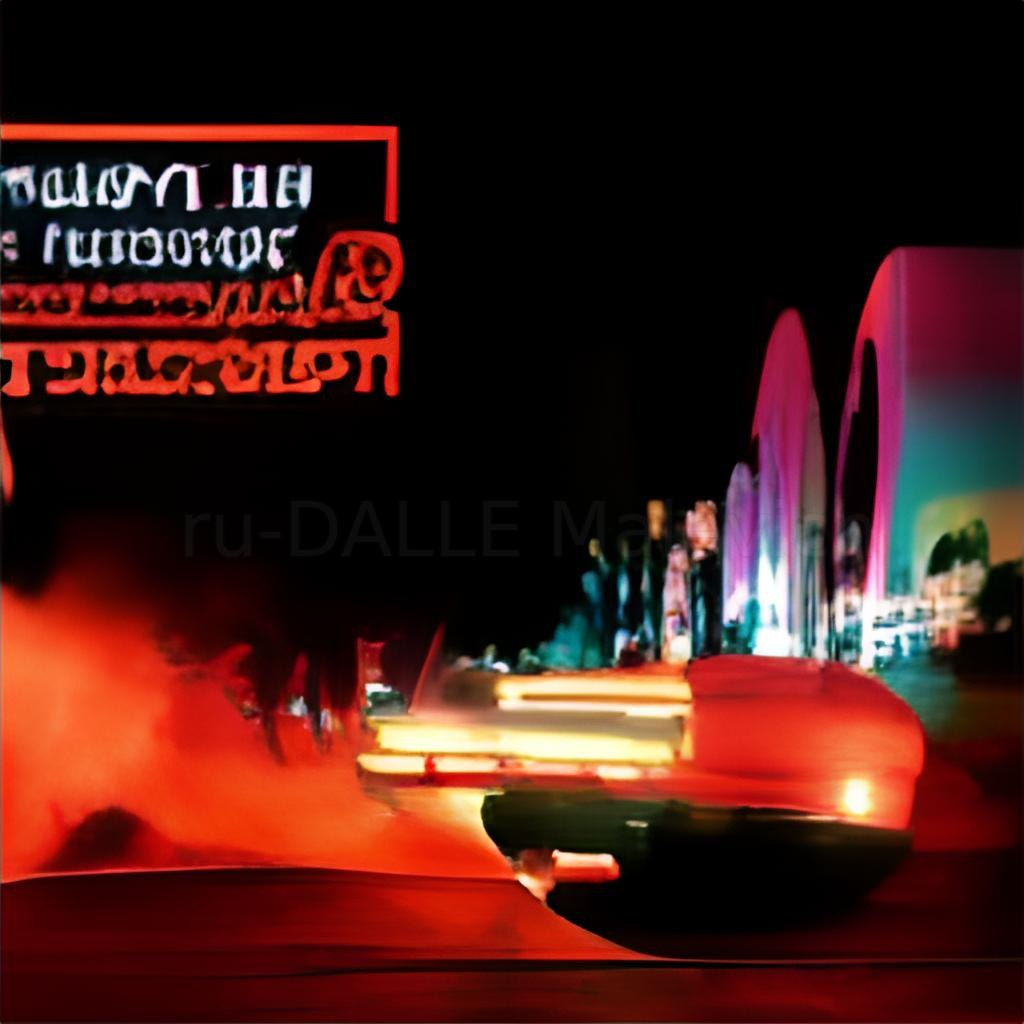

In [33]:
Image("1.jpg")

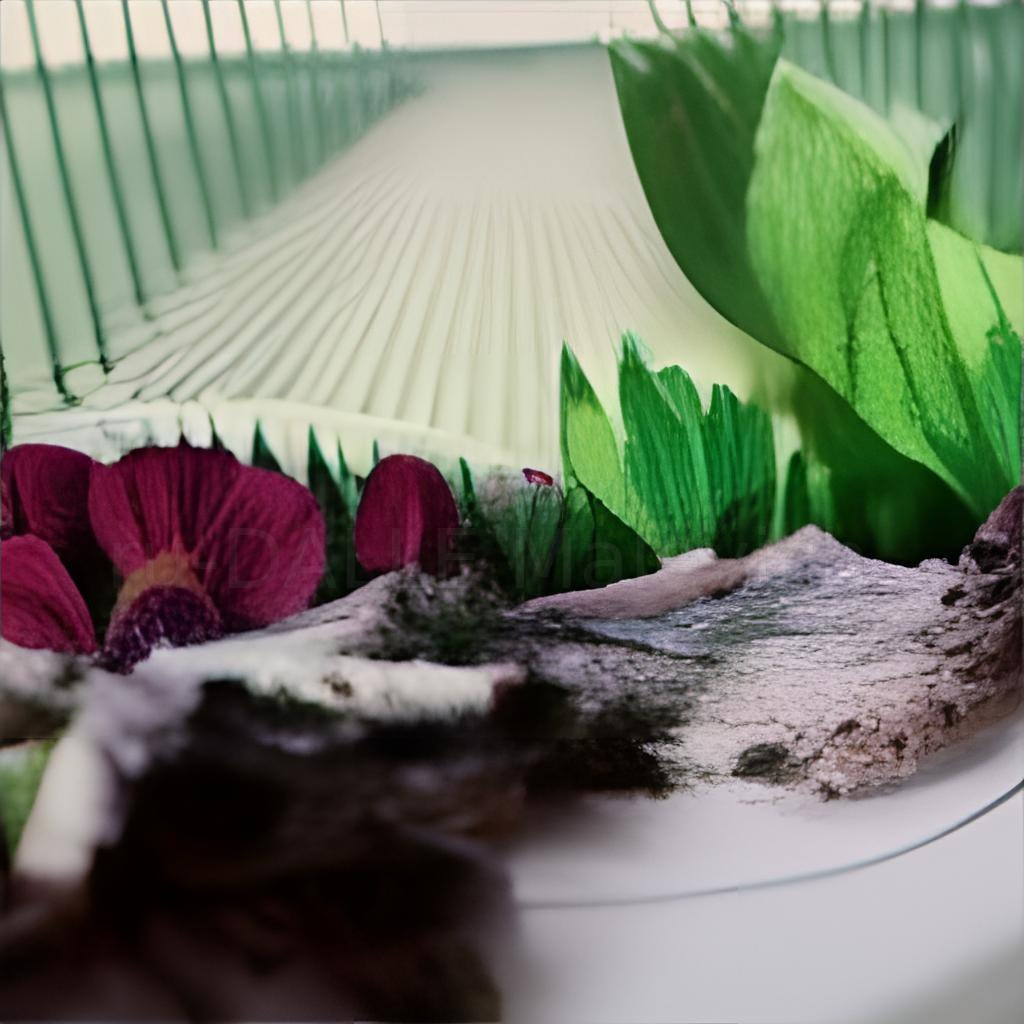

In [36]:
Image("2.jpg")

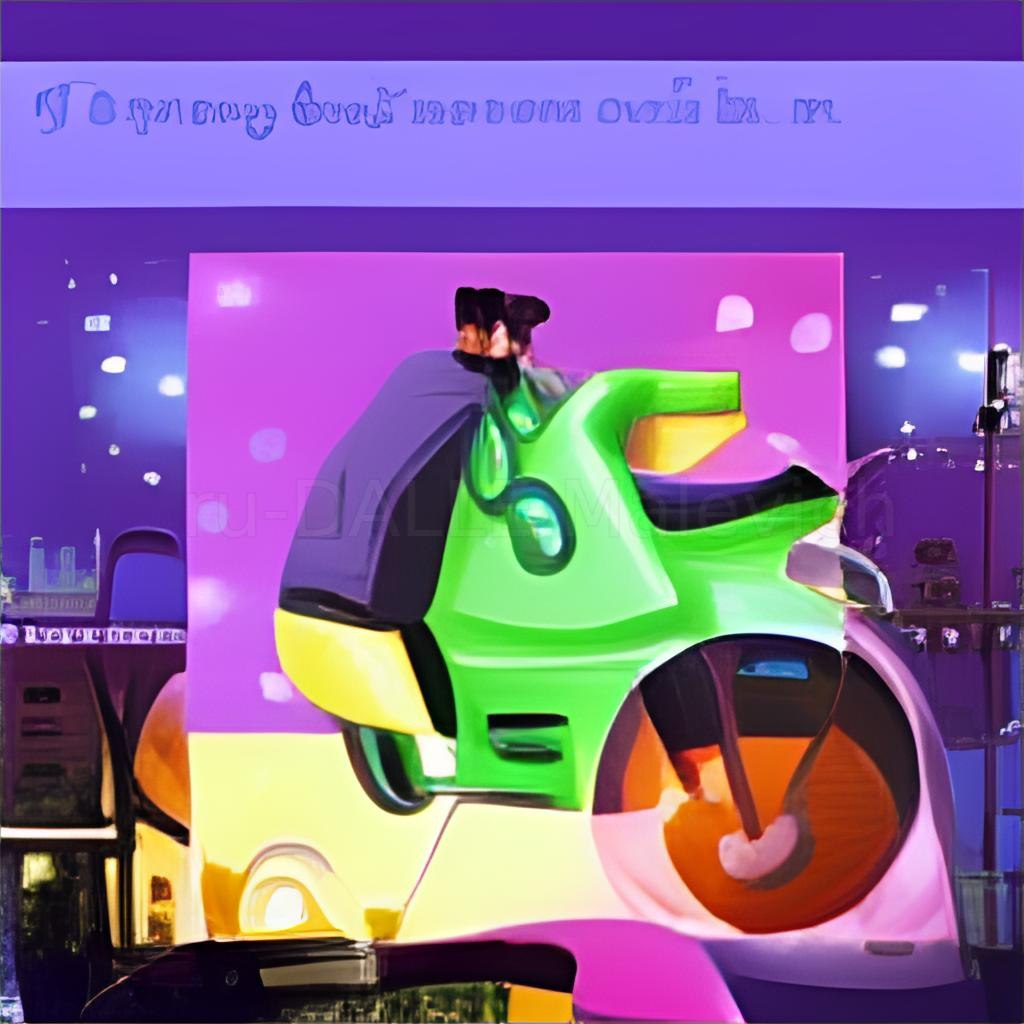

In [37]:
Image("3.jpg")

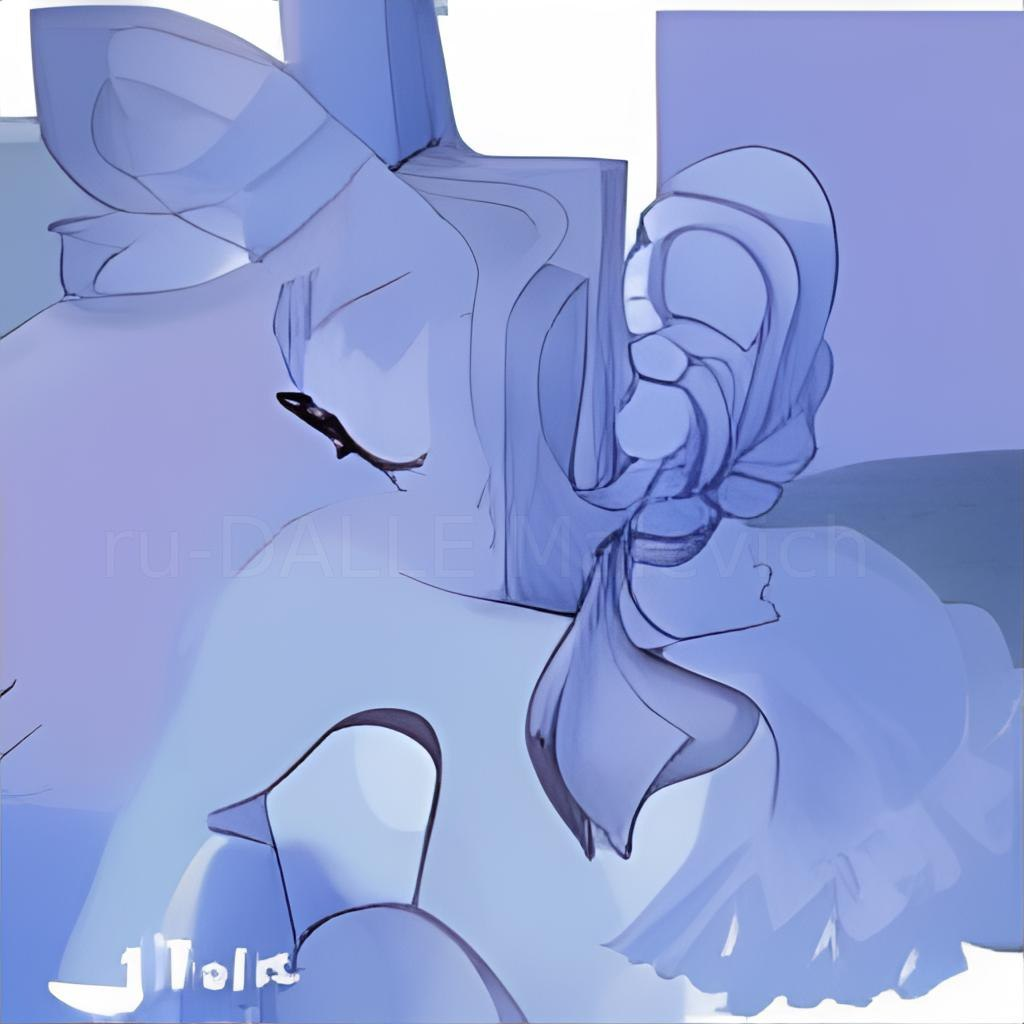

In [38]:
Image("4.jpg")